# [모듈 3.2] SageMaker TensorFlow 훈련 

Download | Structure | Preprocessing (TensorFlow) | **Train Model (TensorFlow)**

### [알림] <font coler="red"> conda_tensorflow2_p36 커널 </font> 과 함께 사용해야 합니다.

* 이 노트북은 `1.1.download_data`, `1.2.structuring_data` 및 `3.1.tensorflow_preprocessing`으로 시작하는 일련의 노트북의 일부입니다.



# 노트북 요약
---
- SageMaker 에서 관리형 EC2 인스턴스로 훈련을 하기 위해서 "훈련 스크립트"의 주요한 내용을 확인 합니다.
- SageMaker Estimator 설정을 하고 모델 훈련을 합니다.
- 훈련된 모델의 가중치를 S3에서 다운로드 받아서 모델을 생성합니다.
- 테스트 데이터 셋트를 생성 합니다.
- 생성된 모델 및 테스트 세트를 통해서 추론을 하고 실제 예측이 잘 되었는지를 확인 합나다.


# 0. 환경 설정
___
TensorFlow를 2.3.1로 업데이트하고 TensorFlow Datasets를 설치합니다.


In [1]:
import pickle
import pathlib
import sagemaker
import subprocess
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from sagemaker.tensorflow import TensorFlow

### 버킷 이름 및 훈련/검증 데이터 셋 로딩


In [2]:
%store -r bucket_name
%store -r train_tf_s3_uri
%store -r val_tf_s3_uri

<pre>
</pre>

# 1. 훈련 스크립트 리뷰
___

Helper 함수

이러한 도우미 함수는 훈련 전에 TFRecords 데이터 세트에 수행해야 하는 변환을 정의합니다. 더 자세한 정보는 이 시리즈의 전처리 가이드를 참조하세요.

In [3]:
!pygmentize "training_tensorflow/tensorflow_train.py" | sed -n 7,27p



def tfrecord_parser(record):
    features = {
        "height": tf.io.FixedLenFeature([], tf.int64),
        "width": tf.io.FixedLenFeature([], tf.int64),
        "depth": tf.io.FixedLenFeature([], tf.int64),
        "label": tf.io.FixedLenFeature([], tf.int64),
        "image_raw": tf.io.FixedLenFeature([], tf.string),
    }
    parsed_features = tf.io.parse_single_example(record, features)
    return tf.io.decode_jpeg(parsed_features["image_raw"]), parsed_features["label"]


def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_hue(image, 0.1)
    return (image, label)



<pre>
</pre>

### 훈련 스크립트 메인 함수
훈련 스크립트는 if 문에서 훈련 코드를 래핑합니다.

In [4]:
!pygmentize "training_tensorflow/tensorflow_train.py" | sed -n 29p

if __name__ == "__main__":


### 입력 파라미터 분석
이러한 입력 파라미터는 하이퍼파라미터 인수와 fit 메소드에 대한 입력 인수를 통해 전달됩니다.

In [5]:
!pygmentize "training_tensorflow/tensorflow_train.py" | sed -n 29,39p

if __name__ == "__main__":

    arg_parser = argparse.ArgumentParser()
    arg_parser.add_argument("--epochs", type=int, default=50)
    arg_parser.add_argument("--batch-size", type=int, default=4)
    arg_parser.add_argument("--learning-rate", type=float, default=0.001)

    arg_parser.add_argument("--train-dir", type=str, default=os.environ.get("SM_CHANNEL_TRAINING"))
    arg_parser.add_argument(
        "--validation-dir", type=str, default=os.environ.get("SM_CHANNEL_VALIDATION")
    )


<pre>
</pre>

### 병렬화 구성을 위해 autotune 사용
- 훈련 속도를 높이기 위해 TensorFlow는 특정 작업을 여러 코어에 분산할 수 있습니다. 작업을 분산할 최적의 작업자 수를 결정하는 것은 어려울 수 있습니다(너무 적으면 GPU 활용도가 낮고 너무 많으면 작업 예약 오버헤드로 인해 지연이 발생함). 
- TensorFlow는 훈련을 수행하는 컴퓨터를 기반으로 적절한 양을 결정하는 방법과 함께 제공됩니다.

In [6]:
!pygmentize "training_tensorflow/tensorflow_train.py" | sed -n 42p

    AUTOTUNE = tf.data.experimental.AUTOTUNE


<pre>
</pre>

### 데이터세트 로드
- 훈련 및 검증 데이터세트가 로드됩니다. 
- 이미지를 TFRecord 파일로 변환할 때 크기 조정이나 스케일을 했기 때문에 다시 수행할 필요가 없습니다.
- 훈련 데이터에는 증강이 적용되지만 검증 데이터에는 적용되지 않습니다. 


In [7]:
!pygmentize "training_tensorflow/tensorflow_train.py" | sed -n 47,65p

    train_ds = tf.data.TFRecordDataset(
        filenames=[train_data.as_posix()], num_parallel_reads=AUTOTUNE
    )

    val_ds = tf.data.TFRecordDataset(filenames=[val_data.as_posix()], num_parallel_reads=AUTOTUNE)

    train_ds = (
        train_ds.map(tfrecord_parser, num_parallel_calls=AUTOTUNE)
        .map(augment, num_parallel_calls=AUTOTUNE)
        .batch(args.batch_size)
        .prefetch(AUTOTUNE)
    )

    val_ds = (
        val_ds.map(tfrecord_parser, num_parallel_calls=AUTOTUNE)
        .batch(args.batch_size)
        .prefetch(AUTOTUNE)
    )



<pre>
</pre>

### GPU를 사용할 수 있는지 확인
GPU를 사용할 수 있는 경우 훈련 장치를 GPU로 설정하고, 그렇지 않으면 CPU를 사용합니다.

In [8]:
!pygmentize "training_tensorflow/tensorflow_train.py" | sed -n 66,71p

    gpu_devices = tf.config.experimental.list_physical_devices("GPU")
    if any(gpu_devices):
        device = gpu_devices[0].device_type
    else:
        device = "/cpu:0"
    print(f"Training with: {device}")


<pre>
</pre>

### 기본 모델 생성 및 수정
- 먼저 장치 컨텍스트를 설정하여 적절한 장치(GPU 또는 CPU)를 사용하고 있는지 확인합니다. 
- 그런 다음 ResNet50 아키텍처를 사용하고 ImageNet 데이터 세트에서 사전 훈련된 가중치로 가중치를 초기화합니다. 
- Pretained 모델의 최상위 계층은 ImageNet 이미지에 대해 구성되어 있으므로 분류 계층(`inlcude_top=False`)을 제거
- 11마리 동물에 대한 분류 계층으로 교체해야 합니다.

In [9]:
!pygmentize "training_tensorflow/tensorflow_train.py" | sed -n 72,80p


    with tf.device(device):

        base_model = tf.keras.applications.ResNet50(include_top=False, weights="imagenet")

        global_avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
        output = tf.keras.layers.Dense(11, activation="softmax")(global_avg)
        model = tf.keras.Model(inputs=base_model.input, outputs=output)



### 옵티마이저 정의 및 모델 학습
이 예에서는 SGD를 사용하여 모델의 가중치를 최적화합니다. 훈련이 끝나면 최고의 검증 정확도를 수행한 에포크에 대한 가중치가 저장되므로 나중에 테스트 데이터 세트에 대한 예측을 위해 모델을 로드할 수 있습니다.

In [10]:
!pygmentize "training_tensorflow/tensorflow_train.py" | sed -n 80,90p


        optimizer = tf.keras.optimizers.SGD(lr=args.learning_rate, momentum=0.9, decay=0.01)

        model.compile(
            loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
        )

        print("Beginning Training...")
        model.fit(train_ds, epochs=args.epochs, validation_data=val_ds, verbose=2)

        model.save("/opt/ml/model/model")


<pre>
</pre>

# 2. SageMaker Estimator 설정 
___

교육에 사용할 리소스와 리소스 구성 방법을 정의합니다. 상세 사항은 아래를 참조 하세요.

- [TensorFlow Estimator](https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/sagemaker.tensorflow.html#tensorflow-estimator)


<a id='idg4b.2'></a>
### 알고리즘 하이퍼파라미터
___
- 하이퍼파라미터는 훈련이 시작되기 전에 설정한 알고리즘의 튜닝 파라미터를 나타냅니다. 일반적으로 기본값으로 미리 설정되어 있으므로 지정하지 않으면 훈련 알고리즘을 계속 실행할 수 있지만 일반적으로 최적의 결과를 얻으려면 조정이 필요합니다. 이러한 값이 무엇인지는 전적으로 데이터 세트에 따라 다릅니다. 
- 불행히도 최고의 설정이 무엇인지 알려주는 공식은 없습니다. 직접 시도하고 결과를 확인해야 하지만 선택하는 데 도움이 되는 모범 사례와 팁이 있습니다.

* **학습률** - 교육의 각 배치 후에 우리는 해당 배치에 대해 가능한 최상의 결과를 제공하기 위해 모델의 가중치를 업데이트합니다. 학습률은 가중치를 업데이트해야 하는 정도를 제어합니다. 모범 사례는 0.2에서 .001 사이의 값을 지정하며 일반적으로 1보다 높지 않습니다. 학습률이 높을수록 훈련이 최적의 가중치로 더 빨리 수렴되지만 너무 빠르면 목표를 초과할 수 있습니다. 이 예에서는 사전 훈련된 모델의 가중치를 사용하므로 가중치가 이미 최적화되어 있고 가중치에서 너무 멀리 이동하고 싶지 않기 때문에 더 낮은 학습률로 시작하려고 합니다.

* **에포크** - 에포크는 훈련 세트의 한 주기를 나타내며 훈련할 에포크가 많다는 것은 정확도를 향상시킬 기회가 더 많다는 것을 의미합니다. 적절한 값은 시간과 예산 제약에 따라 5~25 Epoch 범위입니다. 이상적으로는 검증 정확도가 안정되기 직전에 값이 올바른 Epoch 수 입니다.

* **Batch Size** - 일괄 학습은 RAM에 보관해야 하는 데이터의 양을 줄이고 학습 알고리즘의 속도를 높일 수 있습니다. 이러한 이유로 훈련 데이터는 거의 항상 일괄 처리됩니다. 최적의 배치 크기는 데이터 세트, 이미지 크기 및 훈련 컴퓨터의 RAM 용량에 따라 다릅니다. 우리와 같은 데이터 세트의 경우 합리적인 값은 배치당 18개에서 64개 이미지입니다.



### 훈련을 위한 하이퍼파라미터 정의

In [11]:
hyperparameters = {
    "epochs": 10,
    "batch-size": 32,
    "learning-rate": 0.001,
}

### Estimator 설정

In [12]:
estimator_config = {
    "entry_point": "tensorflow_train.py",
    "source_dir": "training_tensorflow",
    "framework_version": "2.3",
    "py_version": "py37",
    "instance_type": "ml.p3.2xlarge",
    "instance_count": 1,
    "role": sagemaker.get_execution_role(),
    "hyperparameters": hyperparameters,
    "output_path": f"s3://{bucket_name}",
}

In [13]:
tf_estimator = TensorFlow(**estimator_config)

### 훈련 및 검증 데이터 채널 설정

In [14]:
s3_data_channels = {
    "training": train_tf_s3_uri,
    "validation": val_tf_s3_uri,
}

# 3. 모델 훈련
- 총 소요시간이 약 5분 걸립니다.

In [15]:
tf_estimator.fit(s3_data_channels)

2021-12-28 06:23:49 Starting - Starting the training job...
2021-12-28 06:23:51 Starting - Launching requested ML instances......
2021-12-28 06:25:09 Starting - Preparing the instances for training.........
2021-12-28 06:26:31 Downloading - Downloading input data
2021-12-28 06:26:31 Training - Downloading the training image.........
2021-12-28 06:28:07 Training - Training image download completed. Training in progress.2021-12-28 06:28:08.172229: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2021-12-28 06:28:08.174955: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2021-12-28 06:28:08.351002: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.2
2021-12-28 06:28:08.428988: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:4

<pre>

</pre>

# 4. 훈련된 모델 로드 및 테스트 데이터 로딩
___

- 모델 가중치는 S3에 저장이 되고, 다운로드 후에 모델에 가중치를 다시 로드하여 예측을 생성할 수 있습니다. 
- 훈련 후에 테스트 데이터에서 모델을 평가하는 것이 중요합니다. 

### S3에서 훈련된 모델 다운로드 및 압축 해제

In [16]:
sagemaker.s3.S3Downloader().download(tf_estimator.model_data, "training_tensorflow")

In [17]:
import tarfile

tfile = tarfile.open("training_tensorflow/model.tar.gz")
tfile.extractall("training_tensorflow")

### 훈련된 모델 로딩
- 아래 셀을 실행을 하고, 셀이 더 이상 진행이 안되는 경우가 발생할 수 있습니다. 
- 이러한 이유 중의 하나는 OOM (Out of Memory) 이 발생한 상황일 수 있습니다. 
- 메모리 확보(다른 노트북 커널 셧다운 혹은 프로세스 제거 등)를 하여 다시 실행하시기 바랍니다.


In [18]:
try:
    model = tf.keras.models.load_model("training_tensorflow/model")
except Exception:
    import traceback
    traceback.print_exc()   


### 예측을 위해 테스트 데이터 세트에서 이미지 로드

In [19]:
image_folder = tfds.ImageFolder("./data_structured")

In [20]:
def tfrecord_parser(record):
    features = {
        "height": tf.io.FixedLenFeature([], tf.int64),
        "width": tf.io.FixedLenFeature([], tf.int64),
        "depth": tf.io.FixedLenFeature([], tf.int64),
        "label": tf.io.FixedLenFeature([], tf.int64),
        "image_raw": tf.io.FixedLenFeature([], tf.string),
    }
    parsed_features = tf.io.parse_single_example(record, features)
    return tf.io.decode_jpeg(parsed_features["image_raw"]), parsed_features["label"]

In [21]:
test_ds = tf.data.TFRecordDataset(filenames=["data_tfrecord/test.tfrecord"], num_parallel_reads=2)
test_ds = test_ds.map(tfrecord_parser, num_parallel_calls=2).as_numpy_iterator()

#### 모델 예측(0에서 9까지)을 원래 클래스 이름(곰에서 얼룩말까지)에 다시 연결

In [22]:
with open("pickled_data/category_labels.pickle", "rb") as f:
    category_labels = pickle.load(f)

category_labels = {idx: name for idx, name in enumerate(sorted(category_labels.values()))}
category_labels

{0: 'bear',
 1: 'bird',
 2: 'cat',
 3: 'cow',
 4: 'dog',
 5: 'elephant',
 6: 'frog',
 7: 'giraffe',
 8: 'horse',
 9: 'sheep',
 10: 'zebra'}

# 5.모델 추론과 함께 검증 이미지 표시
더 많은 예측을 보려면 셀을 다시 실행하세요.

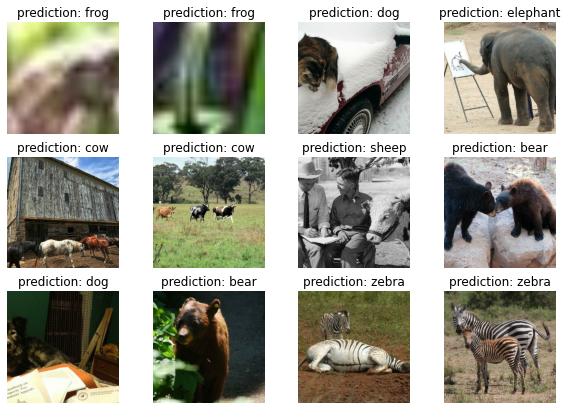

In [23]:
fig, axs = plt.subplots(3, 4, figsize=(10, 7))

for ax in axs.flatten():
    sample = next(iter(test_ds))
    image = sample[0]
    pred = model.predict(tf.expand_dims(image, axis=0))
    pred_name = category_labels[np.argmax(pred)]
    ax.imshow(image)
    ax.axis("off")
    ax.set_title(f"prediction: {pred_name}")

<pre>
</pre>

## 다음 단계

- 이것으로 SageMaker의 TensorFlow 프레임워크에 대한 이미지 데이터 가이드를 마칩니다. 
- 모델을 배포하고 테스트 데이터에 대한 예측을 얻으려면 진행에 필요한 모든 정보를 여기에서 찾을 수 있습니다. 

- [추론을 위한 모델배포](https://docs.aws.amazon.com/sagemaker/latest/dg/deploy-model.html)
